## This will be the codebase for the dictionary learning portion

In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util

In [2]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_bins_t: 3-9
"""
def events2voxelgrid_linear(x,y,timestamp,pol, img_size, num_bins_t, t_min, dt_cell, use_polarity=True):
    assert len(x) == len(y) == len(pol) == len(timestamp)
    num_events = len(x)
    voxelgrid = np.zeros(image.shape+(num_bins_t,), np.float64)
    for i in xrange(num_events-1):
        tn = (timestamp[i] - t_min) / dt_cell
        ti = int(tn)
        dt = tn - ti
        # Voting on two adjacent cells
        polarity = (2.*pol[i] - 1.) if use_polarity else 1.
        voxelgrid[y[i],x[i],ti] += (1. - dt)*polarity
        if ti < num_bins_t-1:
            voxelgrid[y[i],x[i],ti+1] += dt*polarity
    print np.sum(np.abs(voxelgrid)) # This should equal the number of events
    return voxelgrid.astype('float32')

### Parameters of the method

In [3]:
patch_size = (5, 5)
max_patches = 80000  # Due to memory issues

# Event parameters:
num_time_slices = 5

# Method to compute voxel grids of events (time slices): nearest neighbor or linear voting
method_voting = 'linear'

# Split by polarity (double grid size) or not?
split_by_polarity = False

# Dictionary
n_components = 1000

### Read the image

In [4]:
image = io.imread("0.210521.png",as_gray=True).astype('float32')

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [5]:
image.shape

(260, 346)

In [6]:
image.dtype

dtype('float32')

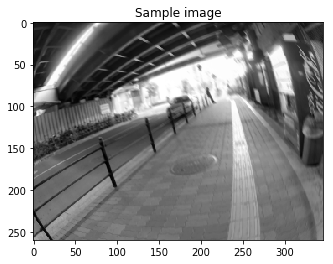

In [7]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [8]:
image_x = ndimage.sobel(image, axis=0).astype('float32')
image_y = ndimage.sobel(image, axis=1).astype('float32')

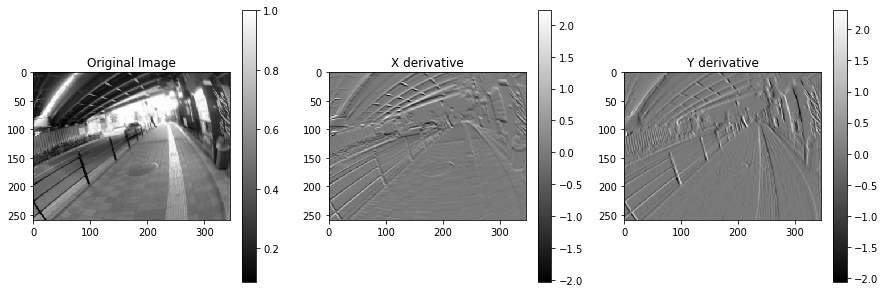

In [9]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

## Create the event histogram

Read events

In [10]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(row[0]))
        y.append(int(row[1]))
        timestamp.append(float(row[2]))
        pol.append(distutils.util.strtobool(row[3]))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [11]:
total_num_events = len(x)

In [12]:
total_num_events

39969

Convert to numpy arrays

In [13]:
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [14]:
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)

In [15]:
if not split_by_polarity:
    # one voxel grid for all events (both polarities)
    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt = np.transpose(np.array([y, x, timestamp]))
        voxelgrid, _ = np.histogramdd(yxt, bins=bin_edges).astype('float32')
        del yxt
    else:
        print('Interpolated histogram')
        voxelgrid = events2voxelgrid_linear(x,y,timestamp,pol, 
                                            image.shape,num_time_slices,t_min,dt_cell,use_polarity=True)
    voxelgrid.shape

Interpolated histogram
34651.11688469224


In [16]:
if split_by_polarity:
    # Positive events only
    idx_pos = pol==0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
        voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges).astype('float32')
        del yxt_pos
    else:
        print('Interpolated histogram')
        voxelgrid_pos = events2voxelgrid_linear(x[idx_pos],y[idx_pos],timestamp[idx_pos],pol[idx_pos], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    voxelgrid_pos.shape

In [17]:
if split_by_polarity:
    # Negative events only
    idx_neg = pol!=0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
        voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges).astype('float32')
        del yxt_neg
    else:
        print('Interpolated histogram')
        voxelgrid_neg = events2voxelgrid_linear(x[idx_neg],y[idx_neg],timestamp[idx_neg],pol[idx_neg], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    voxelgrid_neg.shape

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

In [18]:
if split_by_polarity:
    fig, axs = plt.subplots(int((num_time_slices+1)/2), 2, figsize=(15, 15))
    fig.suptitle('Histogram of positive events')

    for i in range(num_time_slices):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
        plt.colorbar()

    if num_time_slices % 2 == 1:
        # if odd number of plots, hide last one
        axs.flat[-1].set_visible(False)

    plt.show()

In [19]:
if split_by_polarity:
    fig, axs = plt.subplots(int((num_time_slices+1)/2), 2, figsize=(15, 15))
    fig.suptitle('Histogram of negative events')

    for i in range(num_time_slices):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
        plt.colorbar()

    if num_time_slices % 2 == 1:
        # if odd number of plots, hide last one
        axs.flat[-1].set_visible(False)

    plt.show()

### Combine spatial gradient and temporal derivative (events) to create training patches

Stack the spatial gradient and the temporal derivative (events) on a single WxHxZ array to select the patches together on all Z slices with one single call to `extract_patches_2d`

In [20]:
image_gradient = np.concatenate((np.expand_dims(image_x, axis=2), np.expand_dims(image_y, axis=2)), axis=2)
if split_by_polarity:
    voxelgrid = np.concatenate((voxelgrid_pos,voxelgrid_neg), axis=2)
data = np.concatenate((image_gradient, voxelgrid), axis=2)
del image_gradient

In [21]:
data.shape

(260, 346, 7)

In [22]:
data.dtype

dtype('float32')

Extract pacthes

In [23]:
data_patches = image_extractor.extract_patches_2d(data, patch_size, max_patches)
data_patches.shape

(80000, 5, 5, 7)

In [24]:
# Plot the information of this patch:
idx_patch = 31

nrm_large = 0
for i in range(int(max_patches/5)):
    ww = data_patches[i].reshape(patch_size[0],patch_size[1],-1)
    nrm = np.linalg.norm(ww)
    if nrm > nrm_large:
        nrm_large = nrm
        idx_patch = i

idx_patch

2323

(5, 5, 7)


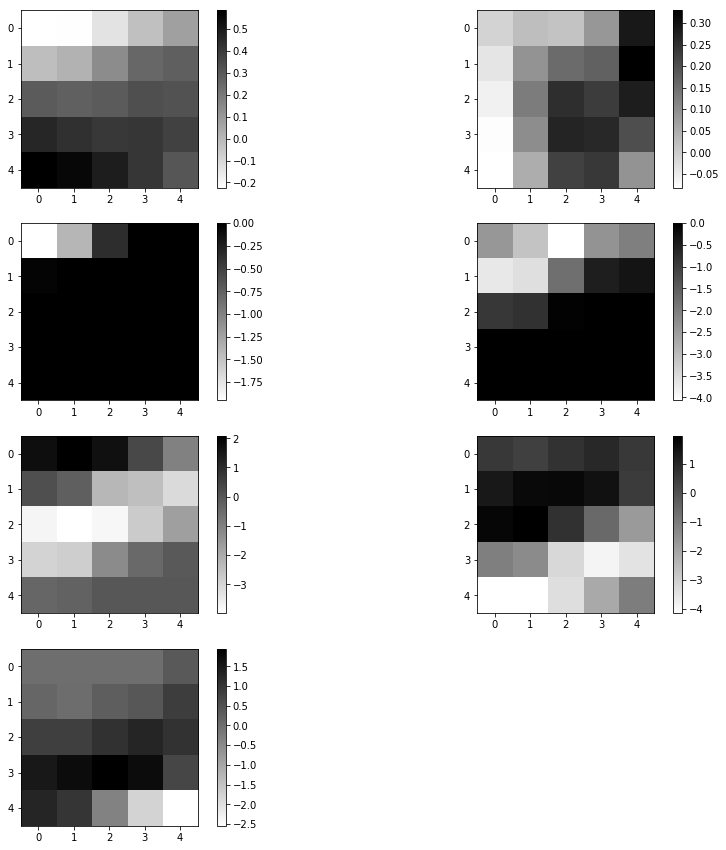

In [25]:
ww = data_patches[idx_patch].reshape(patch_size[0],patch_size[1],-1)
print( ww.shape )
fig, axs = plt.subplots(int((data.shape[2]+1)/2), 2, figsize=(15, 15))
for i in range(data.shape[2]):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(ww[:,:,i], cmap='gray_r')
    plt.colorbar()
    
if data.shape[2] % 2 == 1:
    # if odd number of plots, hide last one
    axs.flat[-1].set_visible(False)

plt.show()

Prepare (reshape) data for call to dictionary learning function

In [26]:
data_patches = data_patches.reshape(data_patches.shape[0], -1)

In [27]:
data_patches.shape

(80000, 175)

In [28]:
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, n_iter=500)

Learning the dictionary...


In [29]:
V = dico.fit(data_patches).components_
V.shape

(1000, 175)

Visualize the atoms:

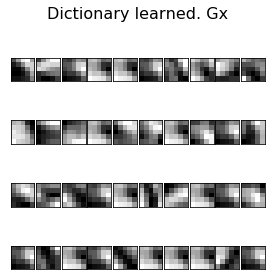

In [30]:
num_atoms_plot = 40
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,0], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Gx\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

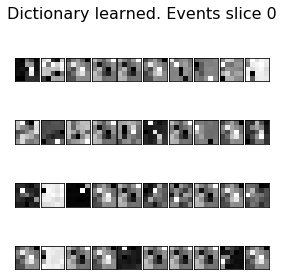

In [31]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Events slice 0\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

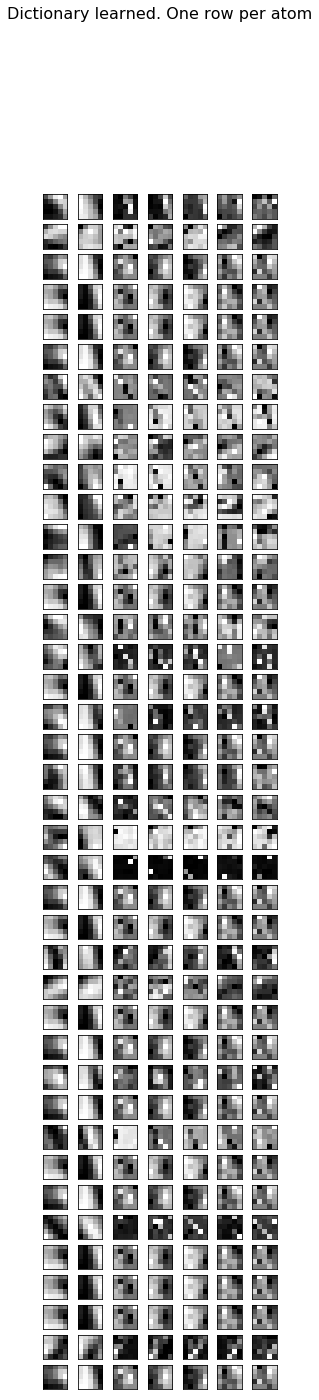

In [32]:
plt.figure(figsize=(4,num_atoms_plot*0.5))
for i, comp in enumerate(V[:num_atoms_plot]):
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    for j in range(data.shape[2]):
        plt.subplot(num_atoms_plot, data.shape[2], data.shape[2]*i + j + 1)
        plt.imshow(atom[:,:,j], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
plt.suptitle('Dictionary learned. One row per atom\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Part of the dictionary corresponding to the spatial gradients (the upper part of V)

In [33]:
num_elem_grads = 2*patch_size[0]*patch_size[1]
V_gradients = V[:,:num_elem_grads]
V_gradients.shape

(1000, 50)

Part of the dictionary corresponding to the events (the bottom part of V)

In [34]:
V_events = V[:,num_elem_grads:]
V_events.shape

(1000, 125)

In [35]:
dico

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=1000, n_iter=500,
              n_jobs=None, positive_code=False, positive_dict=False,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=None, verbose=False)

In [36]:
data_test = image_extractor.extract_patches_2d(voxelgrid, patch_size)
data_test.shape

(87552, 5, 5, 5)

In [37]:
data_test = data_test.reshape(data_test.shape[0], -1)
data_test.shape

(87552, 125)

In [38]:
#n_coefs = 10
#coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs)
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp')

In [39]:
np.transpose(data_test).shape

(125, 87552)

In [40]:
code = coder.transform(data_test)
code.shape

(87552, 1000)

In [41]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

(87552, 50)

In [42]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

(87552, 5, 5, 2)

In [43]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (image.shape[0],image.shape[1],2))
reconstruction.shape

(260, 346, 2)

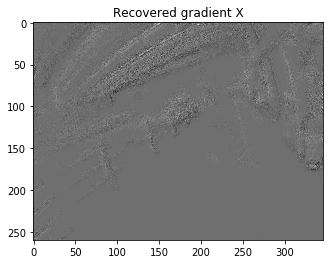

In [44]:
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.title('Recovered gradient X')
plt.show()

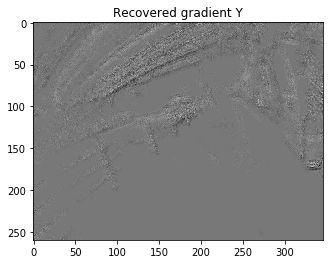

In [45]:
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

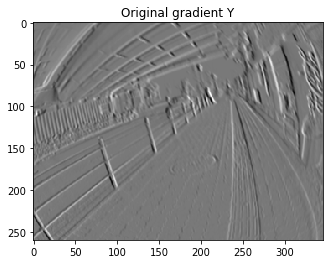

In [46]:
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()

TO DO: 
- [x] compute histograms (Ep,En) using linear voting instead of regular voting
- [x] test with a single voxel grid (with polarity), instead of two (Ep,En)
- [x] better plot the dictionaty. One atom per row
- [x] reconstruction with the learned dictionary
- are gx,gy dominating the largest components? Or are all dimensions independent? Do we need to rescale?
- debug reconstruction. Results do not look good.